Basic model design

In [1]:
import mesa


class MoneyAgent(mesa.Agent):
    """An agent with fixed initial wealth."""

    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1


class MoneyModel(mesa.Model):
    """A model with some number of agents."""

    def __init__(self, N):
        self.num_agents = N
        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)

Introducing time and scheduling

In [2]:
import mesa


class MoneyAgent(mesa.Agent):
    """An agent with fixed initial wealth."""

    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1

    def step(self):
        # The agent's step will go here.
        # For demonstration purposes we will print the agent's unique_id
        print("Hi, I am agent " + str(self.unique_id) + ". My wealth is " + str(self.wealth))
        # print(self.schedule.agents)


class MoneyModel(mesa.Model):
    """A model with some number of agents."""

    def __init__(self, N):
        self.num_agents = N
        self.schedule = mesa.time.RandomActivation(self)
        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            self.schedule.add(a)

    def step(self):
        """Advance the model by one step."""
        self.schedule.step() # randomly selects from all agents

Can iterate one step of the model as shown below:

In [3]:
empty_model = MoneyModel(10)
empty_model.step() 

Hi, I am agent 4. My wealth is 1
Hi, I am agent 3. My wealth is 1
Hi, I am agent 0. My wealth is 1
Hi, I am agent 6. My wealth is 1
Hi, I am agent 7. My wealth is 1
Hi, I am agent 8. My wealth is 1
Hi, I am agent 9. My wealth is 1
Hi, I am agent 2. My wealth is 1
Hi, I am agent 1. My wealth is 1
Hi, I am agent 5. My wealth is 1


Rewriting agent step method to undergo an exchange (random exchange of wealth)

In [4]:
class MoneyAgent(mesa.Agent):
    """An agent with fixed initial wealth."""

    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1

    def step(self):
        if self.wealth == 0:
            return
        other_agent = self.random.choice(self.model.schedule.agents)
        # print(f'self:{self.unique_id}, other:{other_agent.unique_id}')
        other_agent.wealth += 1
        self.wealth -= 1


Running this model

In [5]:
model = MoneyModel(10)
for i in range(10):
    model.step()

We now want to visualise this data

(array([5., 0., 0., 2., 0., 0., 1., 0., 0., 2.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

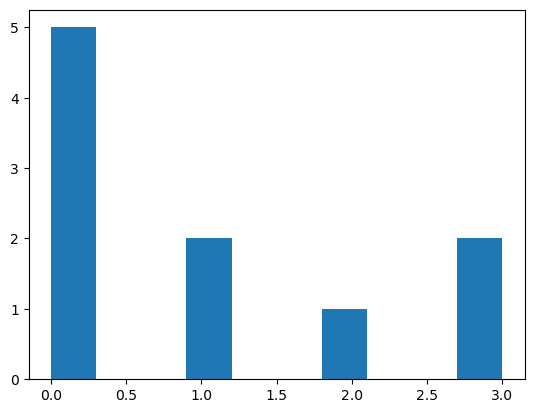

In [6]:
# The below is needed for both notebooks and scripts
import matplotlib.pyplot as plt

agent_wealth = [a.wealth for a in model.schedule.agents]
plt.hist(agent_wealth)

Can repeat these runs to see the distribution that emerges from them 

- This is an alternative to doing a run with many individuals

(array([434., 300., 156.,  74.,  18.,  16.,   1.,   1.]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 <BarContainer object of 8 artists>)

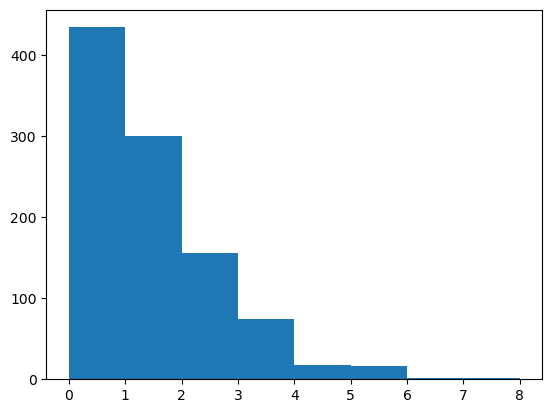

In [7]:
all_wealth = []
# This runs the model 100 times, each model executing 10 steps.
for j in range(100):
    # Run the model
    model = MoneyModel(10)
    for i in range(10):
        model.step()

    # Store the results
    for agent in model.schedule.agents:
        all_wealth.append(agent.wealth)

plt.hist(all_wealth, bins=range(max(all_wealth) + 1))


# Adding Space
We can use a mesa grid to add a spatial component.

Each agent inherently has a pos variable with an (x,y) coordinate tuple. The place_agent method adds this attribute to the agent.

In [8]:
class MoneyModel(mesa.Model):
    """A model with some number of agents."""

    def __init__(self, N, width, height):
        self.num_agents = N
        self.grid = mesa.space.MultiGrid(width, height, True)
        self.schedule = RandomActivation(self)

        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            self.schedule.add(a)

            # Add the agent to a random grid cell
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))

We now need to add a movement function.

This can be done using the get_neighborhood function which tells the agent the occupancy of neighbouring cells.

In [9]:
def move(self):
    possible_steps = self.model.grid.get_neighborhood(
        self.pos,
        moore=True,
        include_center=False)
    new_position = self.random.choice(possible_steps)
    self.model.grid.move_agent(self, new_position)
    
setattr(MoneyAgent, 'move', move)

In [10]:
class MoneyAgent(mesa.Agent):
    """An agent with fixed initial wealth."""

    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1

    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos, moore=True, include_center=False
        )
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def give_money(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        if len(cellmates) > 1:
            other_agent = self.random.choice(cellmates)
            other_agent.wealth += 1
            self.wealth -= 1

    def step(self):
        self.move()
        if self.wealth > 0:
            self.give_money()


class MoneyModel(mesa.Model):
    """A model with some number of agents."""

    def __init__(self, N, width, height):
        self.num_agents = N
        self.grid = mesa.space.MultiGrid(width, height, True)
        self.schedule = mesa.time.RandomActivation(self)
        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            self.schedule.add(a)
            # Add the agent to a random grid cell
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))

    def step(self):
        self.schedule.step()

In [11]:
model = MoneyModel(50, 10, 10)
for i in range(20):
    model.step()

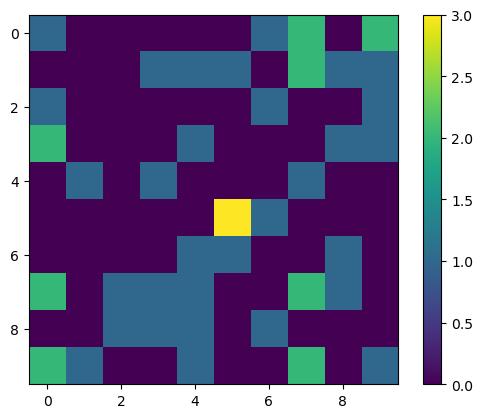

In [12]:
import numpy as np

agent_counts = np.zeros((model.grid.width, model.grid.height))
for cell in model.grid.coord_iter():
    cell_content, x, y = cell
    agent_count = len(cell_content)
    agent_counts[x][y] = agent_count
plt.imshow(agent_counts, interpolation="nearest")
plt.colorbar()

# If running from a text editor or IDE, remember you'll need the following:
# plt.show()

# Data collection

Using the data collector method, one can collect data from both the agents and model.

In this case we will store the agents wealth and the gini coefficient at each step.

Gini coefficient is a measure of the wealth inequality in a group.



In [13]:
def compute_gini(model):
    agent_wealths = [agent.wealth for agent in model.schedule.agents]
    x = sorted(agent_wealths)
    N = model.num_agents
    B = sum(xi * (N - i) for i, xi in enumerate(x)) / (N * sum(x))
    return 1 + (1 / N) - 2 * B


class MoneyAgent(mesa.Agent):
    """An agent with fixed initial wealth."""

    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1

    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos, moore=True, include_center=False
        )
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def give_money(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        if len(cellmates) > 1:
            other = self.random.choice(cellmates)
            other.wealth += 1
            self.wealth -= 1

    def step(self):
        self.move()
        if self.wealth > 0:
            self.give_money()


class MoneyModel(mesa.Model):
    """A model with some number of agents."""

    def __init__(self, N, width, height):
        self.num_agents = N
        self.grid = mesa.space.MultiGrid(width, height, True)
        self.schedule = mesa.time.RandomActivation(self)

        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            self.schedule.add(a)
            # Add the agent to a random grid cell
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))

        self.datacollector = mesa.DataCollector(
            model_reporters={"Gini": compute_gini}, agent_reporters={"Wealth": "wealth"}
        )

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

In [14]:
model = MoneyModel(50, 10, 10)
for i in range(100):
    model.step()

# Extracting data as a dataframe

Extracting the data from the data collector as a pandas dataframe

Here we are extracting model variables

<AxesSubplot:>

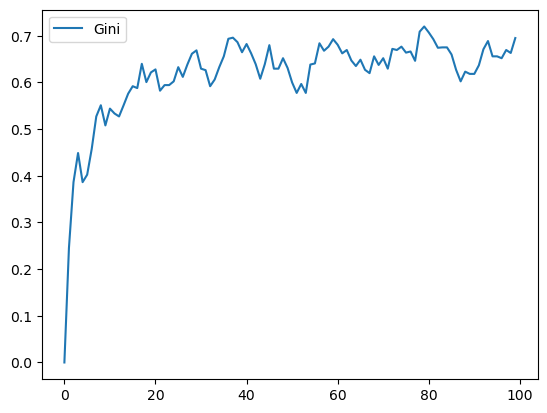

In [15]:
gini = model.datacollector.get_model_vars_dataframe()

gini.plot()

## Extracting agent variables

In [16]:
agent_wealth = model.datacollector.get_agent_vars_dataframe()
agent_wealth.head()

Wealth
Step AgentID        
0    0             1
     1             1
     2             1
     3             1
     4             1

Taking a cross section of the data frame at step 99 then accessing the wealth column

<AxesSubplot:>

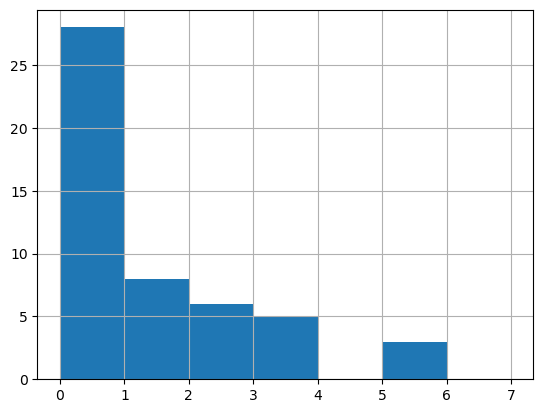

In [17]:
end_wealth = agent_wealth.xs(99, level="Step")["Wealth"]
end_wealth.hist(bins=range(agent_wealth.Wealth.max() + 1))

Accessing a specific agent and their wealth over the course of the simulation

<AxesSubplot:xlabel='Step'>

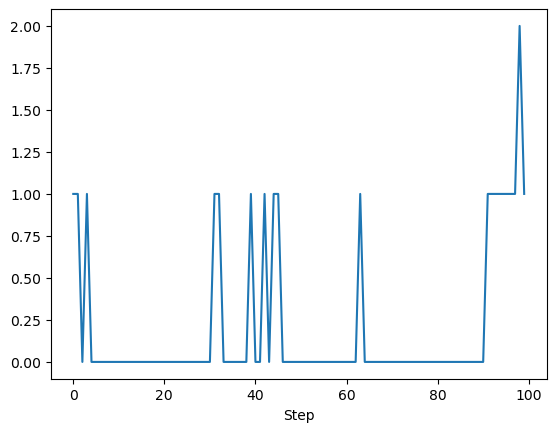

In [18]:
one_agent_wealth = agent_wealth.xs(14, level="AgentID")
one_agent_wealth.Wealth.plot()

# Batch runner

To use the batch runner with a simulation you need to include a self.running attribute. This defines when the batch runner should stop running

In [19]:
def compute_gini(model):
    agent_wealths = [agent.wealth for agent in model.schedule.agents]
    x = sorted(agent_wealths)
    N = model.num_agents
    B = sum(xi * (N - i) for i, xi in enumerate(x)) / (N * sum(x))
    return 1 + (1 / N) - 2 * B


class MoneyModel(mesa.Model):
    """A model with some number of agents."""

    def __init__(self, N, width, height):
        self.num_agents = N
        self.grid = mesa.space.MultiGrid(width, height, True)
        self.schedule = mesa.time.RandomActivation(self)
        self.running = True

        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            self.schedule.add(a)
            # Add the agent to a random grid cell
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))

        self.datacollector = mesa.DataCollector(
            model_reporters={"Gini": compute_gini}, agent_reporters={"Wealth": "wealth"}
        )

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

## Defining Batch run parameters
We call batch_run with the following arguments:

model_cls The model class that is used for the batch run.

parameters A dictionary containing all the parameters of the model class and desired values to use for the batch run as key-value pairs. Each value can either be fixed ( e.g. {"height": 10, "width": 10}) or an iterable (e.g. {"N": range(10, 500, 10)}). batch_run will then generate all possible parameter combinations based on this dictionary and run the model iterations times for each combination.

number_processes If not specified, defaults to 1. Set it to None to use all the available processors. Note: Multiprocessing does make debugging challenging. If your parameter sweeps are resulting in unexpected errors set number_processes = 1.

iterations The number of iterations to run each parameter combination for. Optional. If not specified, defaults to 1.

data_collection_period The length of the period (number of steps) after which the model and agent reporters collect data. Optional. If not specified, defaults to -1, i.e. only at the end of each episode.

max_steps The maximum number of time steps after which the model halts. An episode does either end when self.running of the model class is set to False or when model.schedule.steps == max_steps is reached. Optional. If not specified, defaults to 1000.

display_progress Display the batch run progress. Optional. If not specified, defaults to True.

In the following example, we hold the height and width fixed, and vary the number of agents. We tell the batch runner to run 5 instantiations of the model with each number of agents, and to run each for 100 steps.

We want to keep track of

the Gini coefficient value and

the individual agent’s wealth development.

Since for the latter changes at each time step might be interesting, we set data_collection_period = 1.

Note: The total number of runs is 245 (= 49 different populations * 5 iterations per population). However, the resulting list of dictionaries will be of length 6186250 (= 250 average agents per population * 49 different populations * 5 iterations per population * 101 steps per iteration).

Note for Windows OS users: If you are running this tutorial in Jupyter, make sure that you set number_processes = 1 (single process). If number_processes is greater than 1, it is less straightforward to set up. You can read Mesa’s collect

In [ ]:
params = {"width": 10, "height": 10, "N": range(10, 500, 10)} # Defining starting params as well as the range of params to run through

results = mesa.batch_run(
    MoneyModel, # Runs this model
    parameters=params, # With these starting params for the model
    iterations=5, # Repeats the simulation n times for each set of parameters
    max_steps=100, # Maximum number of time steps after which the model stops (useful if the model is set to repeat until a certain goal has been reached and not within a time limit)
    number_processes=1, # Number of processors (Will need to look up how to run with multiple processors however) 
    data_collection_period=1, # Length of period after which the which the model and agent data collectors collect data
    display_progress=True, # Produces progress bar
)

# Interpreting the resulting data

Here we see the dictionary keys that are within the dataframe

In [21]:
import pandas as pd

results_df = pd.DataFrame(results)
print(results_df.keys())

Index(['RunId', 'iteration', 'Step', 'width', 'height', 'N', 'Gini', 'AgentID',
       'Wealth'],
      dtype='object')


Accessing dataframe

We are filtering for step 100 of all simulations and specifically agent 0. Then through the agent, we are accessing the total number of agents and gini values. Finally we scatter plot the resulting gini coefficients for simulations with different numbers of agents. 

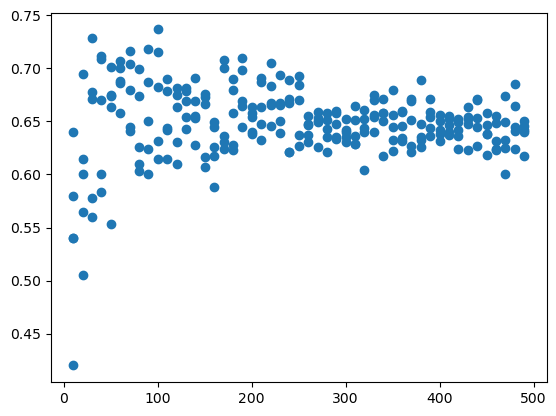

In [22]:
results_filtered = results_df[(results_df.AgentID == 0) & (results_df.Step == 100)]
N_values = results_filtered.N.values
gini_values = results_filtered.Gini.values
plt.scatter(N_values, gini_values)

Here we are accessing the 2nd simulation of the 10 agent simulation set 

In [23]:
# First, we filter the results
one_episode_wealth = results_df[(results_df.N == 10) & (results_df.iteration == 2)]
# Then, print the columns of interest of the filtered data frame
print(
    one_episode_wealth.to_string(
        index=False, columns=["Step", "AgentID", "Wealth"], max_rows=25
    )
)
# For a prettier display we can also convert the data frame to html, uncomment to test in a Jupyter Notebook
from IPython.display import display, HTML
display(HTML(one_episode_wealth.to_html(index=False, columns=['Step', 'AgentID', 'Wealth'], max_rows=25)))

 Step  AgentID  Wealth
    0        0       1
    0        1       1
    0        2       1
    0        3       1
    0        4       1
    0        5       1
    0        6       1
    0        7       1
    0        8       1
    0        9       1
    1        0       1
    1        1       1
  ...      ...     ...
   99        8       1
   99        9       0
  100        0       1
  100        1       2
  100        2       1
  100        3       2
  100        4       0
  100        5       0
  100        6       1
  100        7       2
  100        8       1
  100        9       0


Step,AgentID,Wealth
0,0,1
0,1,1
0,2,1
0,3,1
0,4,1
0,5,1
0,6,1
0,7,1
0,8,1
0,9,1


Here we are accessing the agent 0 of the 1st iteration of the 10 agent simulation set.

In [24]:
results_one_episode = results_df[
    (results_df.N == 10) & (results_df.iteration == 1) & (results_df.AgentID == 0)
]
print(results_one_episode.to_string(index=False, columns=["Step", "Gini"], max_rows=25))

 Step  Gini
    0  0.00
    1  0.18
    2  0.18
    3  0.18
    4  0.32
    5  0.32
    6  0.18
    7  0.18
    8  0.18
    9  0.32
   10  0.32
   11  0.46
  ...   ...
   89  0.58
   90  0.58
   91  0.58
   92  0.58
   93  0.64
   94  0.64
   95  0.64
   96  0.64
   97  0.64
   98  0.64
   99  0.64
  100  0.64


Importing various required modules

In [128]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as constant
from scipy.optimize import curve_fit
import math
from tqdm.notebook import tqdm, trange
import ipywidgets as widgets
import mesa
import pandas as pd
from matplotlib.patches import Circle

# Attempt to introduce continuous space

Beginning with a simple place and move agent model

In [224]:
class MoneyAgent(mesa.Agent):
    """An agent with fixed initial wealth."""

    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self._velocity = [1,1]
        self.radius = 2
        self.mass = 1
        
    @property
    def velocity(self):
        return self._velocity
    
    @velocity.setter
    def velocity(self, value):
        self._velocity = value
    
    @property
    def velocity_magnitude(self):
        return np.linalg.norm(self._velocity)
    
    def move(self):
        
        # print(f'Position {self.pos} + velocity {self._velocity} * time step {self.model.time_step}')
        
        new_position = self.pos + np.array(self._velocity)*self.model.time_step
        # new_position = [sum(x) for x in zip([self.pos],self._velocity*self.model.time_step)]
        
        # print(f'New position {new_position}')

        self.model.space.move_agent(self, new_position)
        
    def collision_check(self):
        # This collision checking will define the dynamics of the collision
        # potential_collision_partners = self.model.space.get_neighbors(self.pos, radius = 200, include_center = False)
        potential_collision_partners = self.model.space.get_neighbors(self.pos, radius = self.radius, include_center = False)
        
        if potential_collision_partners:
            # print(f'potential collision partners: {[z.unique_id for z in potential_collision_partners]}')

            for other in potential_collision_partners:
                if self == other: 
                    # print(f'no collision')
                    continue
                # print(f'Collision between {self.unique_id} and {potential_collision_partners[0].unique_id}')
                self.collision(other)
                


    def collision(self,other):
        self_velocity = np.array(self._velocity)
        other_velocity = np.array(other._velocity)
        self_pos = np.array(self.pos)
        other_pos = np.array(other.pos)
        self_velocity = self_velocity - (2*other.mass/(self.mass+other.mass))*(self_pos-other_pos)/np.linalg.norm(self_pos-other_pos)**2
        other_velocity = other_velocity - (2*self.mass/(self.mass+other.mass))*(other_pos-self_pos)/np.linalg.norm(other_pos-self_pos)**2
        # print(self_velocity)
        # print(other_velocity)
        self._velocity = tuple(self_velocity)
        other._velocity = tuple(other_velocity)
        
        
    def step(self):
        self.collision_check()
        self.move()

    def draw(self, ax):
        """Add this Particle's Circle patch to the Matplotlib Axes ax."""

        circle = Circle(xy=self.pos, radius=self.radius/2)
        ax.add_patch(circle)
    
    def overlap(self):
        potential_collision_partners = self.model.space.get_neighbors(self.pos, radius = self.radius, include_center = False)
        
        if potential_collision_partners:
            # print(f'overlap found at {self.pos}')
            return True
        else:
            return False

        

class MoneyModel(mesa.Model):
    """A model with some number of agents."""

    def __init__(self, N, width, height, time_step):
        self.num_agents = N
        self.space = mesa.space.ContinuousSpace(x_max = 0.5*width, y_max = 0.5*height, torus = True, x_min = -0.5*width, y_min = -0.5*height)
        self.schedule = mesa.time.RandomActivation(self)
        self.time_step = time_step
        
        # Create agents
        for i in range(self.num_agents):
            
            a = MoneyAgent(i, self)
            
            self.schedule.add(a)
            # Add the agent to a random grid cell
            x = self.random.uniform(self.space.x_min, self.space.x_max)
            y = self.random.uniform(self.space.x_min, self.space.x_max)

            self.space.place_agent(a, (x, y))
            if a.overlap():
                self.schedule.remove(a)

#             no_overlap = True
#             while no_overlap:
                
#                 if "a" in locals():
#                     self.schedule.remove(a)
                
#                 a = MoneyAgent(i, self)
#                 self.schedule.add(a)
#                 # Add the agent to a random grid cell
#                 x = self.random.uniform(self.space.x_min, self.space.x_max)
#                 y = self.random.uniform(self.space.x_min, self.space.x_max)

#                 self.space.place_agent(a, (x, y))
#                 no_overlap = a.overlap()
                    
        
        self.datacollector = mesa.DataCollector(
            model_reporters=None, agent_reporters={"Speed": "velocity_magnitude"}
        )
            
    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()
        
    def plot_2D(self):
        fig, ax = plt.subplots()
        plt.rcParams["figure.figsize"] = (10,10)
        ax.set_xlim(self.space.x_min, self.space.x_max)
        ax.set_ylim(self.space.y_min, self.space.y_max)
        
        for agent in self.schedule.agents:
            agent.draw(ax)
        


In [227]:
model = MoneyModel(1000, 100, 100, 1)
model_length = 100
for i in tqdm(range(model_length)):
    # print(f'step {i}')
    model.step()
# model.step()

  0%|          | 0/100 [00:00<?, ?it/s]

577


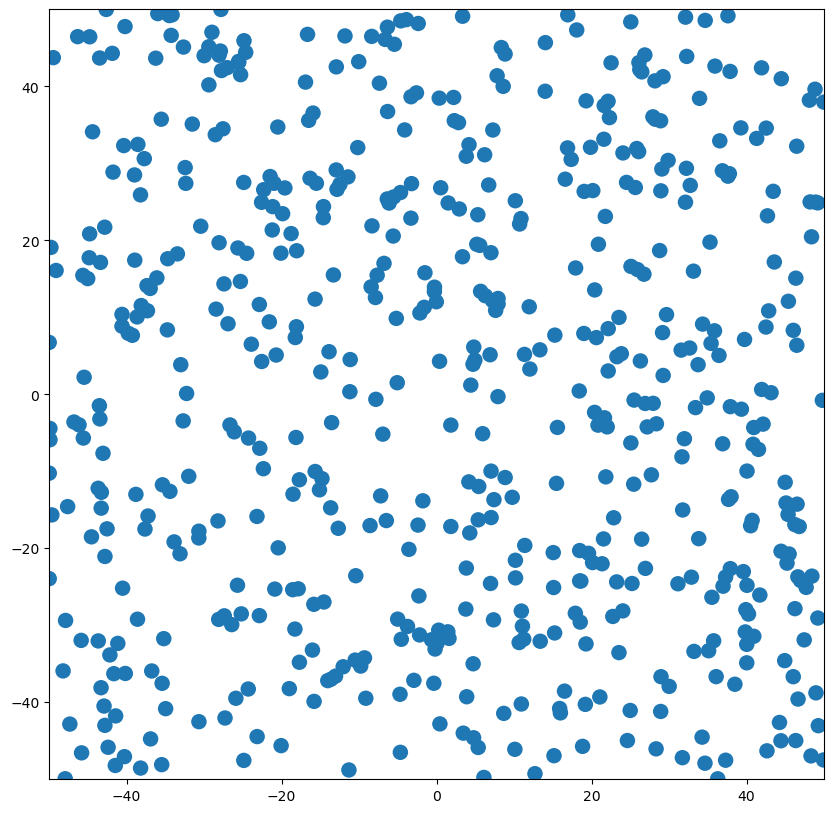

In [228]:
model.plot_2D()
print(len(model.schedule.agents))

                  Speed
Step AgentID           
999  995       3.956307
     996       8.161379
     997       9.000860
     998       3.591049
     999      14.311502


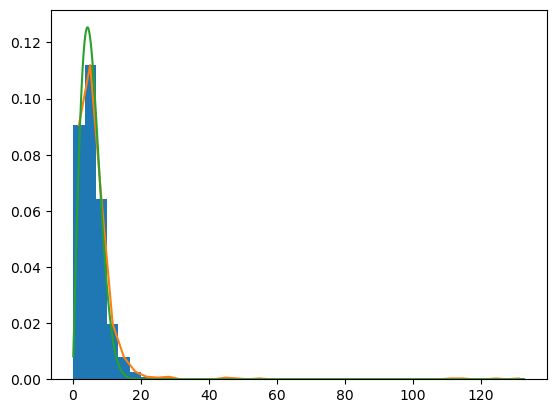

In [92]:
def Maxwell_Boltzmann_2D(v,v_offset = 0, alpha = 0.2, k = 1, l = 1):
    return k*2*alpha*(v-v_offset)*np.exp(-alpha*l*(v-v_offset)**2)

velocities = model.datacollector.get_agent_vars_dataframe()
print(velocities.tail())
final_velocities = velocities.xs(model_length-1, level="Step")["Speed"]
bin_heights, bin_edges, _ = plt.hist(final_velocities,bins = 40, density = True, stacked = True)
bin_centres = bin_edges[:-1] + np.diff(bin_edges)/2
plt.plot(bin_centres,bin_heights)
opt_params, pcov = curve_fit(Maxwell_Boltzmann_2D, bin_centres, bin_heights, p0=[0, 0.0025, 1], bounds = (0,50))
perr = perr = np.sqrt(np.diag(pcov))
x_interval_for_fit = np.linspace(bin_edges[0], bin_edges[-1], 10000)
fit_y = Maxwell_Boltzmann_2D(x_interval_for_fit, *opt_params)
plt.plot(x_interval_for_fit, fit_y, label = 'f')

In [28]:
# model = MoneyModel(2, 10, 10)
# for i in range(20):
#     model.step()

p = np.array((1,2))
p1 = np.array((2,3))
p2 = np.array((4,5))
p3 = p + p1 - p2
print(type(p))
print(type([p]))

print(np.array(p)*2)

<class 'numpy.ndarray'>
<class 'list'>
[2 4]


In [29]:
p = (1,1)
c = np.array(p)
print(c,p)
p = c 
print(tuple(p))

[1 1] (1, 1)
(1, 1)
